<a href="https://colab.research.google.com/github/andreas31603/MachineLearningTasks/blob/main/Task10/MLP_Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Langkah 1: Memuat dataset
file_path = '/content/sample_data/winequality-white.csv'
data = pd.read_csv(file_path, sep=';')

In [ ]:
# Langkah 2: Eksplorasi Data
# Deskripsi statistik
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

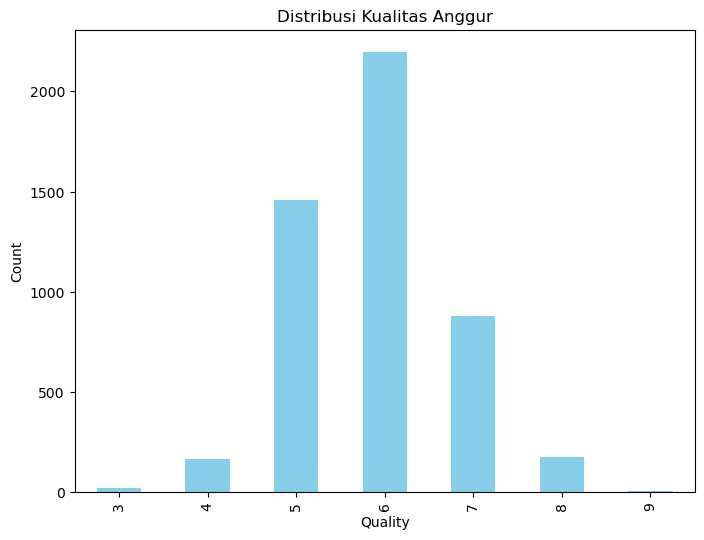

In [ ]:
# Visualisasi distribusi target
plt.figure(figsize=(8, 6))
data['quality'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribusi Kualitas Anggur')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.savefig('Task10MLPRegresion/distribusi_kualitas.png')
plt.show()

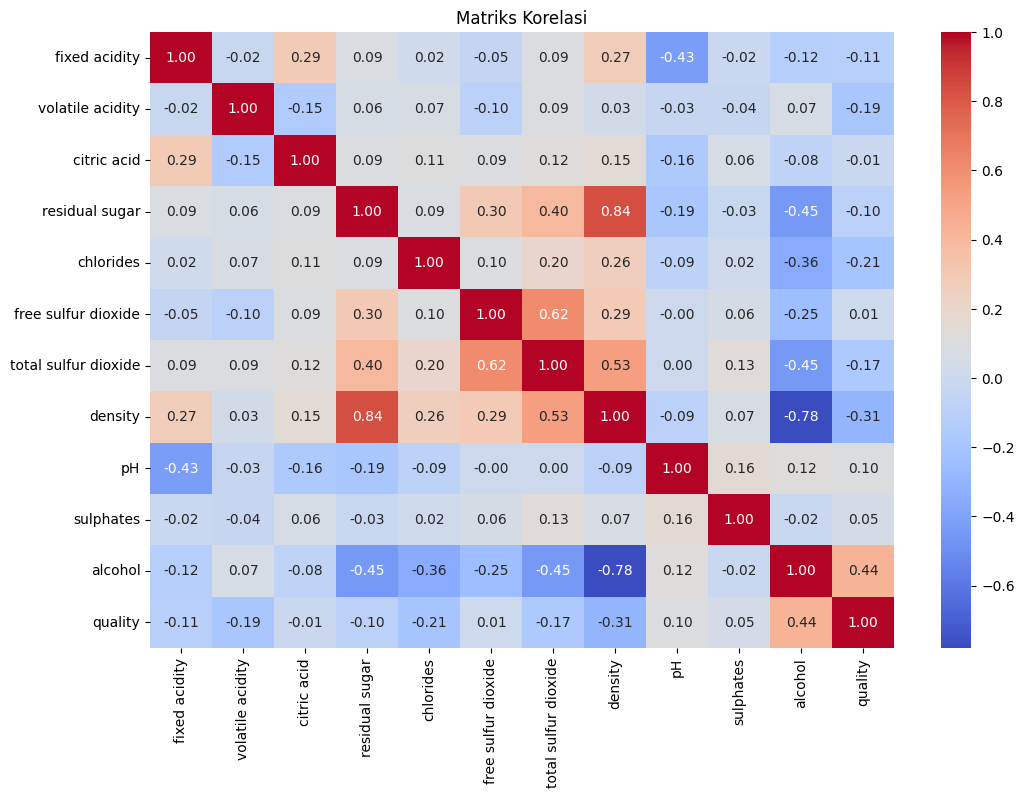

In [5]:
# Visualisasi korelasi
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi')
plt.savefig('Task10MLPRegresion/matriks_korelasi.png')
plt.show()

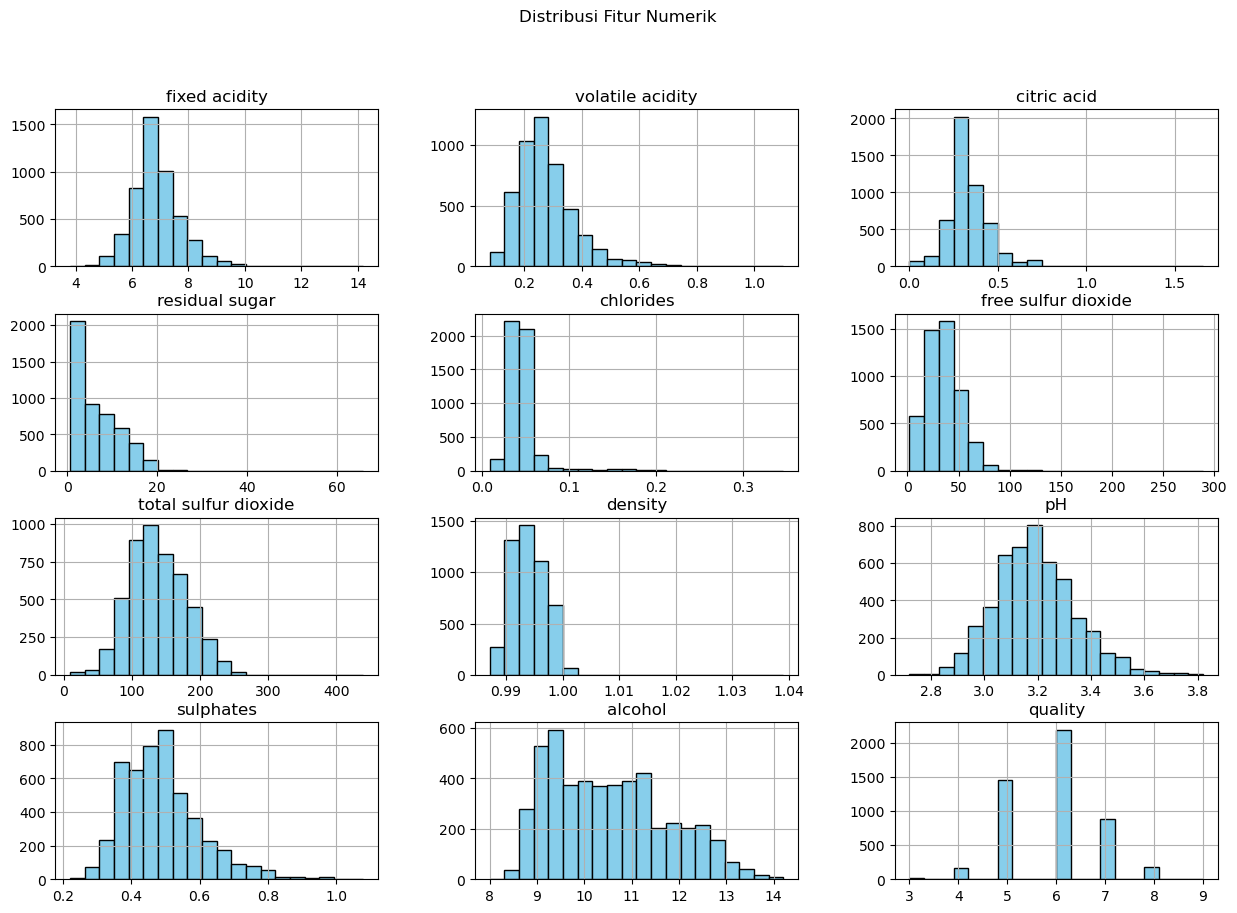

In [ ]:
# Visualisasi distribusi fitur numerik
data.hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribusi Fitur Numerik')
plt.savefig('Task10MLPRegresion/distribusi_fitur_numerik.png')
plt.show()


In [ ]:
# Langkah 3: Pemisahan Fitur dan Target
X = data.drop(columns=['quality'])
y = data['quality']

# Normalisasi fitur
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split dataset
X_train, X_rest, y_train, y_rest = train_test_split(X_normalized, y, train_size=3000, random_state=42)
X_test, y_test = X_rest, y_rest

# Konversi data ke Tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [ ]:
# Langkah 4: Definisi Model Vanilla MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModel, self).__init__()
        layers = []
        current_input_size = input_size
        for units in hidden_layers:
            layers.append(nn.Linear(current_input_size, units))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            elif activation_fn == 'linear':
                pass  # Tidak ada aktivasi tambahan
            elif activation_fn == 'softmax':
                layers.append(nn.Softmax(dim=1))  # Softmax digunakan di lapisan tersembunyi
            current_input_size = units
        layers.append(nn.Linear(current_input_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Langkah 5: Loop Hiperparameter
results = []
hyperparameters = {
    'hidden_layers': [[4], [8], [16], [32], [64], [4, 8], [8, 16], [32, 64], [16, 32, 64]],
    'activation_fn': ['linear', 'sigmoid', 'relu', 'softmax', 'tanh'],
    'learning_rate': [10, 1, 0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64, 128, 256],
    'epochs': [1, 10, 25, 50, 100, 250]
}

for hidden_layers in hyperparameters['hidden_layers']:
    for activation_fn in hyperparameters['activation_fn']:
        for learning_rate in hyperparameters['learning_rate']:
            for batch_size in hyperparameters['batch_size']:
                for epochs in hyperparameters['epochs']:
                    print(f"Training with hidden_layers={hidden_layers}, activation_fn={activation_fn}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

                    # Model, Loss, Optimizer
                    model = MLPModel(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=activation_fn)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                    # DataLoader
                    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                    # Training Loop
                    model.train()
                    for epoch in range(epochs):
                        for inputs, targets in train_loader:
                            optimizer.zero_grad()
                            outputs = model(inputs)
                            loss = criterion(outputs, targets)
                            loss.backward()
                            optimizer.step()

                    # Evaluation
                    model.eval()
                    with torch.no_grad():
                        test_outputs = model(X_test_tensor)
                        test_loss = criterion(test_outputs, y_test_tensor).item()
                        mae = torch.mean(torch.abs(test_outputs - y_test_tensor)).item()

                    # Simpan hasil
                    results.append({
                        'hidden_layers': str(hidden_layers),
                        'activation_fn': activation_fn,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'loss': test_loss,
                        'mae': mae
                    })


Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=1
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=10
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=25
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=50
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=100
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=16, epochs=250
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=32, epochs=1
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=32, epochs=10
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=32, epochs=25
Training with hidden_layers=[4], activation_fn=linear, learning_rate=10, batch_size=32, epochs=50
Training with hidden

In [ ]:
# Langkah 6: Menyimpan dan Visualisasi Hasil
results_df = pd.DataFrame(results)
results_df.to_csv('Task10MLPRegresion/pytorch_hyperparameter_results.csv', index=False)

In [ ]:
# Menampilkan 10 kombinasi hyperparameter terbaik berdasarkan loss
top_10_results = results_df.nsmallest(10, 'loss')
print("10 kombinasi hyperparameter terbaik berdasarkan loss:")
print(top_10_results)
top_10_results.to_csv('top_10_hyperparameter_results.csv', index=False)

10 kombinasi hyperparameter terbaik berdasarkan loss:
     hidden_layers activation_fn  learning_rate  batch_size  epochs      loss  \
5492      [32, 64]       sigmoid          0.010          16      25  0.477159   
5493      [32, 64]       sigmoid          0.010          16      50  0.479223   
6411  [16, 32, 64]          relu          0.010         128      50  0.479764   
6392  [16, 32, 64]          relu          0.010          16      25  0.480947   
5699      [32, 64]          relu          0.001         256     250  0.481570   
3275          [64]       sigmoid          0.001          16     250  0.481592   
4157        [4, 8]          relu          0.010          64     250  0.481774   
6692  [16, 32, 64]          tanh          0.010          16      25  0.482184   
3423          [64]          relu          0.001          16      50  0.482485   
3443          [64]          relu          0.001         128     250  0.483584   

           mae  
5492  0.539199  
5493  0.542257  
641

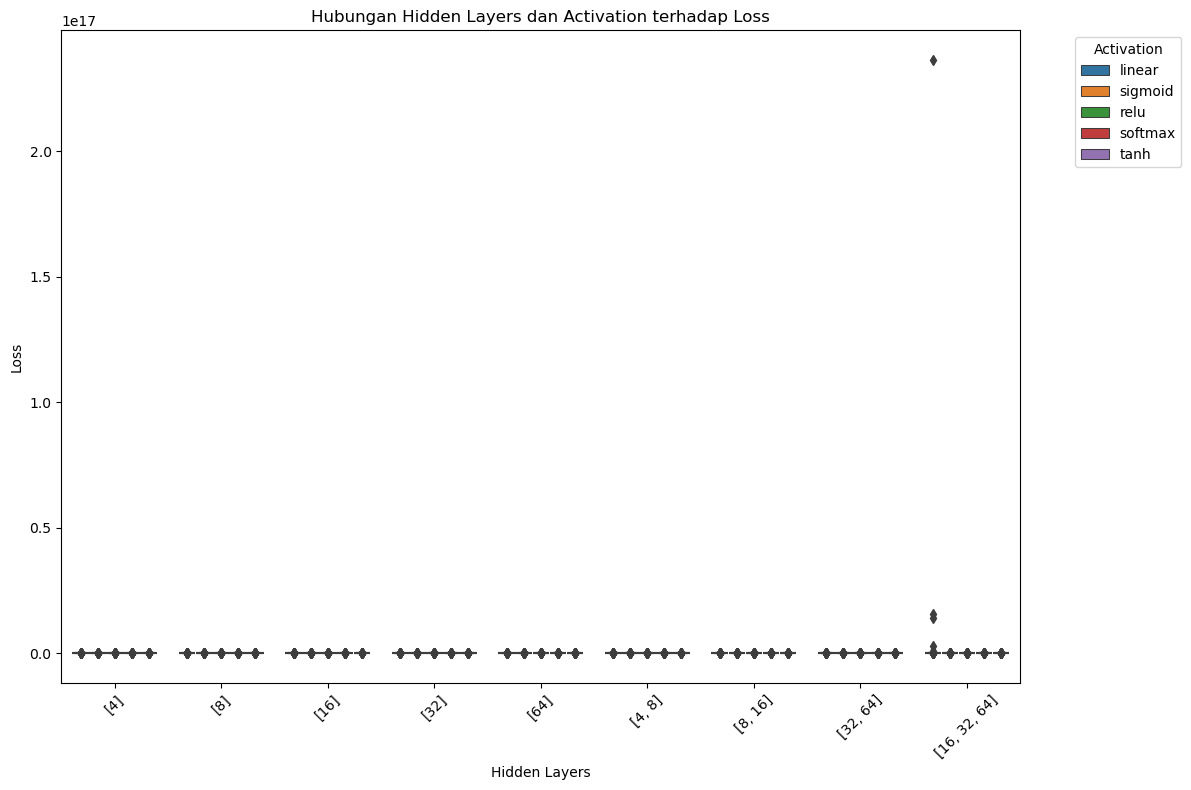

In [ ]:
# Visualisasi hubungan antara hidden_layers dan activation_fn terhadap loss
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='hidden_layers', y='loss', hue='activation_fn')
plt.title('Hubungan Hidden Layers dan Activation terhadap Loss')
plt.ylabel('Loss')
plt.xlabel('Hidden Layers')
plt.xticks(rotation=45)
plt.legend(title='Activation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Task10MLPRegresion/hidden_activation_loss_pytorch.png')
plt.show()

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a le

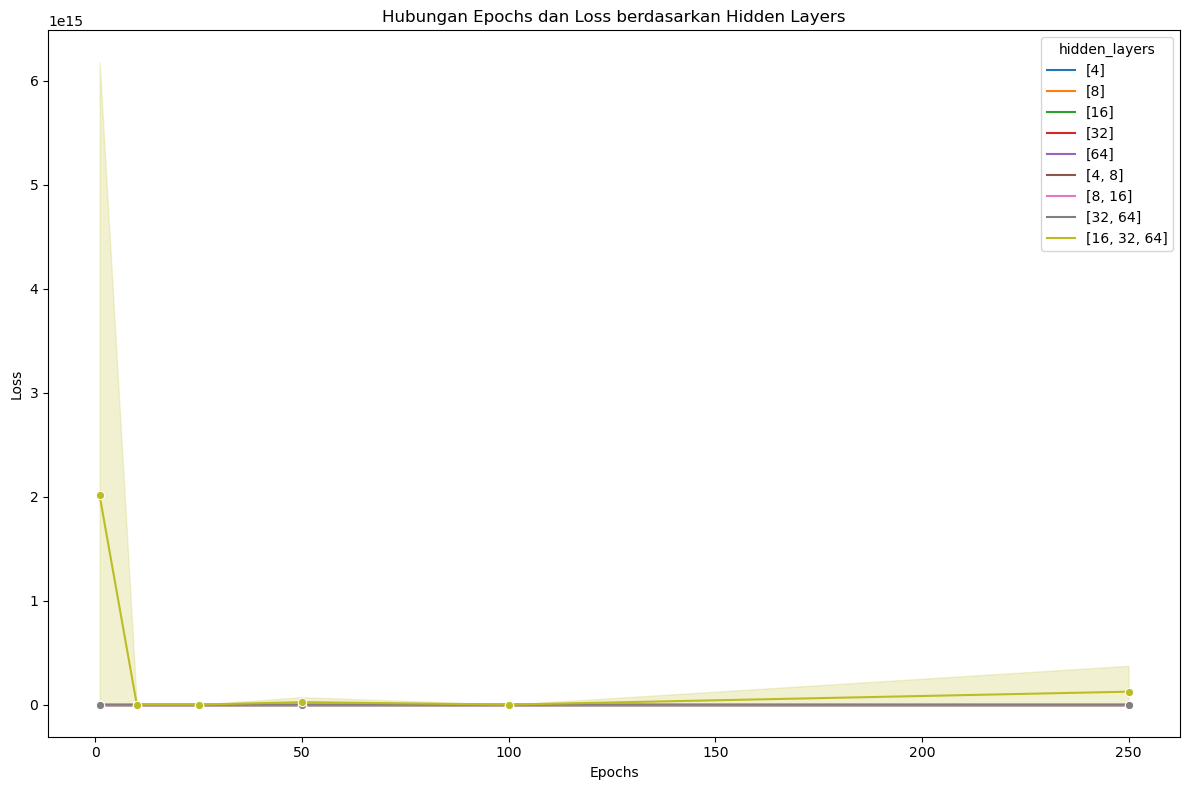

In [ ]:
# Visualisasi hubungan antara epochs dan loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='epochs', y='loss', hue='hidden_layers', marker='o')
plt.title('Hubungan Epochs dan Loss berdasarkan Hidden Layers')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.tight_layout()
plt.savefig('Task10MLPRegresion/epochs_loss_hidden_layers_pytorch.png')
plt.show()

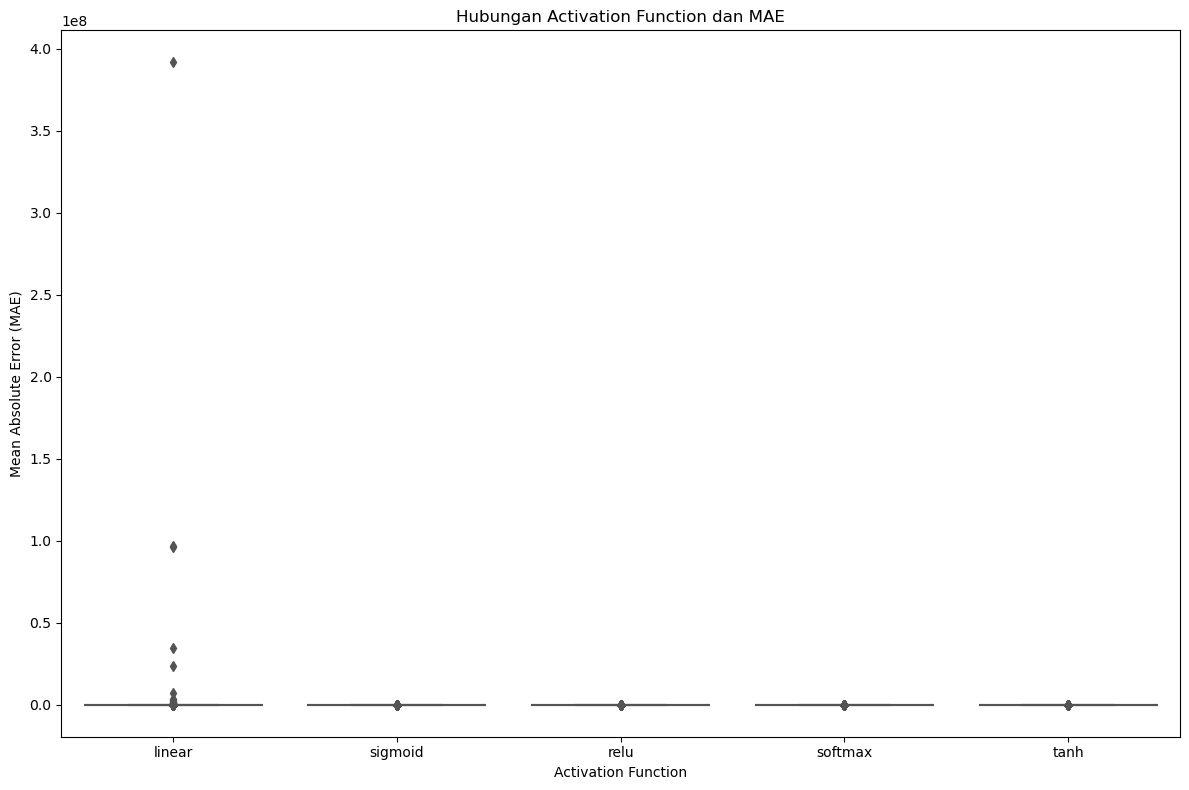

Task10MLPRegresion/Hasil hyperparameter tuning disimpan ke pytorch_hyperparameter_results.csv


In [ ]:
# Visualisasi hubungan antara activation_fn dan mae
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='activation_fn', y='mae', palette='muted')
plt.title('Hubungan Activation Function dan MAE')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig('activation_fn_mae_pytorch.png')
plt.show()

print("Task10MLPRegresion/Hasil hyperparameter tuning disimpan ke pytorch_hyperparameter_results.csv")

In [ ]:
# Load the results from the CSV file where hyperparameter results are stored
results_file = 'Task10MLPRegresion\pytorch_hyperparameter_results.csv'

# Read the CSV file
results_df = pd.read_csv(results_file)

# Get the top 10 hyperparameter combinations based on the lowest loss
top_10_results = results_df.nsmallest(10, 'loss')

# Display the top 10 results
top_10_results

,hidden_layers,activation_fn,learning_rate,batch_size,epochs,loss,mae
5492,"[32, 64]",sigmoid,0.010,16,25,0.477159,0.539199
5493,"[32, 64]",sigmoid,0.010,16,50,0.479223,0.542257
6411,"[16, 32, 64]",relu,0.010,128,50,0.479764,0.546583
6392,"[16, 32, 64]",relu,0.010,16,25,0.480947,0.547372
5699,"[32, 64]",relu,0.001,256,250,0.481570,0.542964
3275,[64],sigmoid,0.001,16,250,0.481592,0.543475
4157,"[4, 8]",relu,0.010,64,250,0.481774,0.550002
6692,"[16, 32, 64]",tanh,0.010,16,25,0.482184,0.553084
3423,[64],relu,0.001,16,50,0.482485,0.545185
3443,[64],relu,0.001,128,250,0.483584,0.543536
